In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import numpy.ma as ma
from geopy.distance import vincenty
import matplotlib.colors as colors
import warnings
import math
import scipy.io as sio

import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D

from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import warnings

# from salishsea_tools import (
#     nc_tools,
#     viz_tools,
# )

%matplotlib inline

In [2]:
mean_tidal_speed = sio.loadmat('/mnt/storage0/jacquielee/data/TIDAL/mean_tide_speed.mat', 
                       struct_as_record=False, squeeze_me=True)
# This tidal velocity grid is already interpolated onto the NEMO grid - presumably ANHA4

In [3]:
print(mean_tidal_speed.keys())

['mean_speed', '__version__', '__header__', '__globals__']


In [4]:
mean_speed = mean_tidal_speed['mean_speed']

In [5]:
mean_speed.shape

(800, 544)

In [6]:
grid = nc.Dataset('/home/jacquielee/data/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy = grid.variables['Bathymetry'][:]
bathy = ma.masked_values(bathy[:,:],0)

In [7]:
bathy.shape

(800, 544)

In [8]:
anhamask = (ma.getmaskarray(bathy[:,:]))*1

In [9]:
mean_speed0 = ma.array(mean_speed,mask=anhamask)

/home/jacquielee/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


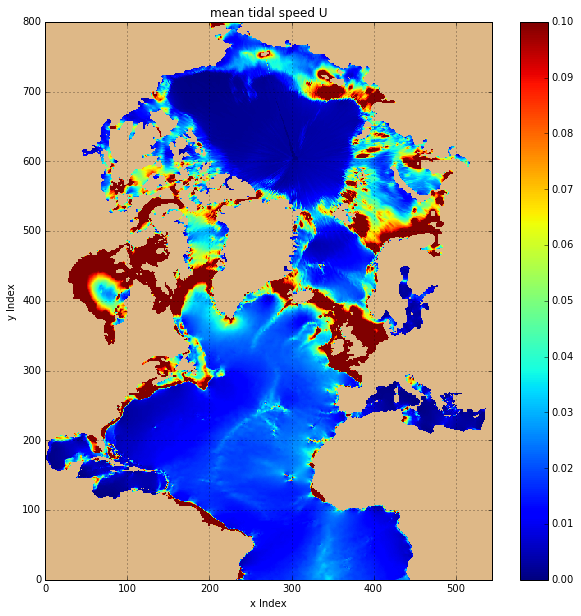

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(mean_speed0,cmap=cmap,vmin = 0.0,vmax=0.1)
cbar = fig.colorbar(mesh,ax=ax)
plt.axis((0, mean_speed.shape[1], 0, mean_speed.shape[0]))
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title('mean tidal speed U')

In [ ]:
# tidal_mean = np.zeros_like(bathy, dtype=float)
# tidal_mean[:574,:486] = mean_speed0
# tidal_mean = np.ma.masked_where(tidal_mean[:,:] == 0.0, tidal_mean)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# cmap = plt.get_cmap('jet')
# cmap.set_bad('burlywood')
# mesh = ax.pcolormesh(tidal_mean,cmap=cmap)
# cbar = fig.colorbar(mesh,ax=ax)
# plt.axis((0, tidal_mean.shape[1], 0, tidal_mean.shape[0]))
# ax.grid()

# ax.set_xlabel('x Index')
# ax.set_ylabel('y Index')

First step is to define the baroclinic tidal energy in the region. To do this, the hsquare values will be used and the buoyancy frequency must be calculated over model fields. The buoyancy frequency will be calculated using TEOS-10

In [10]:
import gsw

In [16]:
tracers = nc.Dataset('/mnt/storage0/jacquielee/research/data/Jasper/ANHA4-EXH004_y2004m09d07_gridT.nc')

In [ ]:
tracers.variables

In [17]:
depth = tracers.variables['deptht']
sal = tracers.variables['vosaline'][0,:,:,:]
temp = tracers.variables['votemper'][0,:,:,:]

In [18]:
lat = tracers.variables['nav_lat'][:,:]
lon = tracers.variables['nav_lon'][:,:]

In [ ]:
print(depth.shape,sal.shape,temp.shape,lat.shape,lon.shape)

In [ ]:
# zlevel = 0
# temper_tz = temp[zlevel, 450:800,50:544]

# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# #viz_tools.set_aspect(ax)
# cmap = plt.get_cmap('jet')
# cmap.set_bad('burlywood')
# mesh = ax.pcolormesh(temper_tz, cmap=cmap)
# cbar = fig.colorbar(mesh)
# plt.axis((0, temper_tz.shape[1], 0, temper_tz.shape[0]))

# ax.grid()

# ax.set_xlabel('x Index')
# ax.set_ylabel('y Index')
# cbar.set_label('{label} [{units}]'.format(label=temper.long_name.title(), units=temper.units))
# ax.set_title(u't = {t:.1f}Day, depth \u2248 {d:.2f}{z.units}'.format(t=7, d=zlevels[zlevel], z=zlevels))

In [19]:
z = np.arange(0,50)
x = np.arange(0,544)
y = np.arange(0,800)

In [ ]:
p = np.zeros_like(sal,dtype=float)

for dep in z:
    print(dep)

    for j in y:
         p[dep,j,:] = gsw.p_from_z(depth[dep,],lat[j,0])


In [ ]:
p.dump('/mnt/storage0/jacquielee/data/p_ANHA4-EXH004_y2004m09d07.npy')

In [20]:
p = np.load('/mnt/storage0/jacquielee/data/p_ANHA4-EXH004_y2004m09d07.npy')

In [ ]:
# SA = np.zeros_like(sal,dtype=float)
# for dep in z:
#     print(dep)ls
#     for i in x:
#         for j in y:
#             SA[dep,j,i] = gsw.SA_from_SP(sal[dep,j,i],p[dep,j,i],lon[j,i],lat[j,i])
# SA.dump('/mnt/storage0/jacquielee/data/SA_ANHA4-EXH004_y2004m09d07.npy')

In [ ]:
def Nsquared(SA, CT, p, lat=None):
    r"""Calculates the buoyancy frequency squared (N^2)(i.e. the Brunt-Väisälä
    frequency squared) at the mid pressure from the equation,
    .. math::
        N^2 = g^2 \frac{\partial\rho}{\partial p}

    Parameters
    ----------
    SA : array_like
         Absolute Salinity  [g/kg]
    CT : array_like
         Conservative Temperature [:math:`^\circ` C (ITS-90)]
    p : array_like
        sea pressure  [dbar]
    lat : array_like, optional
          latitude in decimal degrees north [-90..+90]
          If lat is not supplied, a default gravitational acceleration of
          9.7963 m/s^2 (Griffies, 2004) will be used.

    Returns
    -------
    N2 : array_like
         Brunt-Väisälä frequency squared [1 s :math:`-2`]
    p_mid : array_like
            Mid pressure between p grid [dbar]

    See Also
    --------
    TODO

    Notes
    -----
    This routine uses rho from the computationally efficient 48-term expression
    for density in terms of SA, CT and p.  Also that the pressure increment,
    :math:`\partial p`, in the above formula is in Pa, so that it is 10^4 times
    the pressure increment in dbar.

    The 48-term equation has been fitted in a restricted range of parameter
    space, and is most accurate inside the "oceanographic funnel" described in
    McDougall et al. (2011).  The GSW library function "infunnel(SA, CT, p)" is
    available to be used if one wants to test if some of one's data lies
    outside this "funnel".

    Examples
    --------
    TODO

    References
    ----------
    .. [1] IOC, SCOR and IAPSO, 2010: The international thermodynamic equation
    of seawater - 2010: Calculation and use of thermodynamic properties.
    Intergovernmental Oceanographic Commission, Manuals and Guides No. 56,
    UNESCO (English), 196 pp. See section 3.10 and Eqn. (3.10.2).

    ..[2] McDougall T.J., P.M. Barker, R. Feistel and D.R. Jackett, 2011:  A
    computationally efficient 48-term expression for the density of
    seawater in terms of Conservative Temperature, and related properties
    of seawater.

    ..[3] Griffies, S. M., 2004: Fundamentals of Ocean Climate Models.
    Princeton, NJ: Princeton University Press, 518 pp + xxxiv.

    Modifications:
    2011-03-22. Trevor McDougall & Paul Barker
    """

    if lat != None:
        g = gsw.grav(lat, p)
    else:
        g = 9.7963  # Standard value from Griffies (2004).

    SA, CT, p, g = np.broadcast_arrays(SA, CT, p, g)

    p_mid = 0.5 * (p[1:, ...] + p[:-1, ...])

    drho = (gsw.rho(SA[1:, ...], CT[1:, ...], p_mid) -
            gsw.rho(SA[:-1, ...], CT[:-1, ...], p_mid))

    grav_local = 0.5 * (g[1:, ...] + g[:-1, ...])
    dp = p[1:, ...] - p[:-1, ...]

    N2 = grav_local ** 2 * drho / (gsw.db2Pascal * dp)

    return N2, p_mid

In [ ]:
# nsquare = np.zeros_like(p)
# # for dep in z:
# #     print(dep)
# for i in x:
#     for j in y:
#             #print(nsquare[j,i],sal[:,j,i],temp[:,j,i],p[:,j,i],lat[j,i])
#             SA = sal[:,j,i]
#             CT = temp[:,j,i]
#             press = p[:,j,i]
#             lats = lat[j,i]
#             nsquare[1:,j,i],p_mid = Nsquared(SA,CT,press,lat = lats)

SA = sal[:,500,400]
CT = temp[:,500,400]
press = p[:,500,400]
lats = lat[500,400]
nsquare,p_mid = Nsquared(SA,CT,press,lat = lats)
print(nsquare)

In [ ]:
nsquare.dump('/mnt/storage0/jacquielee/data/nsquare_ANHA4-EXH004_y2004m09d07.npy')

In [21]:
nsquare = np.load('/mnt/storage0/jacquielee/data/nsquare_ANHA4-EXH004_y2004m09d07.npy')
#print(nsquare[:,500,400])

In [22]:
hsquare = np.load('/mnt/storage0/jacquielee/data/h2_anhafull_unsmoothed.npy')
rho_0 = 1024.0
q = 1.0/3.0
kappa = 2.0*math.pi/10.0

In [18]:
#find the bottom most value of nsquare using bathymetric data.
grid = nc.Dataset('/home/jacquielee/data/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy = grid.variables['Bathymetry']
bathy = ma.masked_values(bathy[:],0)

In [23]:
n_b = np.load('/mnt/storage0/jacquielee/data/anha4_nb_clomatology.npy')

In [24]:
E = 0.5*rho_0*n_b*kappa*hsquare*(mean_speed0**2)

In [25]:
E.dump('/mnt/storage0/jacquielee/data/E_ANHA4-EXH004_y2004m09d07.npy')

In [2]:
E = np.load('/mnt/storage0/jacquielee/data/E_ANHA4-EXH004_y2004m09d07.npy')

In [22]:
print(lon.shape,lat.shape,E.shape)

(800, 544) (800, 544) (800, 544)


In [26]:
from netCDF4 import Dataset

nrows = 800
ncols = 544

netfile = Dataset('/mnt/storage0/jacquielee/data/E(x,y).nc', 'w', format='NETCDF3_64BIT')

In [ ]:
E = ma.array(E,mask=anhamask)

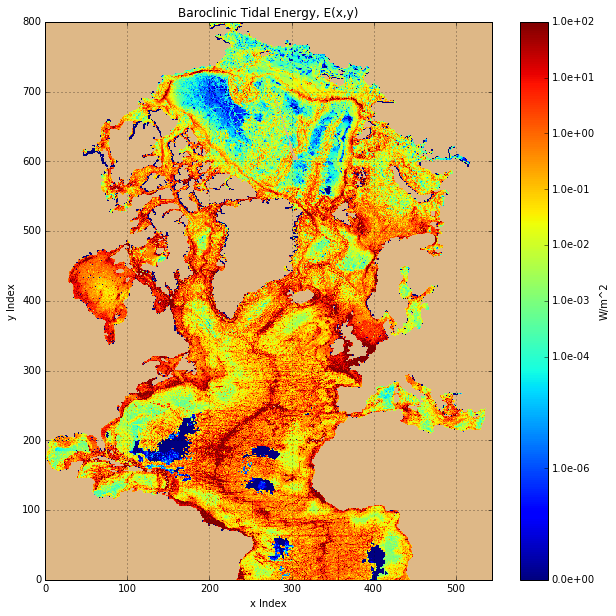

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
#clines = ax.contour(E,0.0,colors='white')
mesh = ax.pcolormesh(E,norm=colors.SymLogNorm(linthresh=0.00000001, 
                                              linscale=0.00000001,vmin=0.0, vmax=100),cmap=cmap)

cbar = fig.colorbar(mesh,ticks=[0.0,10e-7,10e-5,10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2],ax=ax,format='%.1e')
cbar.set_label('W/m^2')
plt.axis((0, E.shape[1], 0, E.shape[0]))

#clines = ax.contour(E,0.0,colors='white')
ax.grid()
ax.set_title('Baroclinic Tidal Energy, E(x,y)')
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')

In [28]:
#nsquare average is defined at each z level.
nsquare_avg = np.zeros_like(hsquare, dtype=float)
for i in x:
    print(i)
    for j in y:
            #print(dep, nsquare[dep,500,400],np.sum(nsquare[dep:-1,500,400]))
        nsquare_avg[j,i] = (np.sum(nsquare[0:-1,j,i]))/(50)
nsquare_avg.dump('/mnt/storage0/jacquielee/data/nsquare_avg_ANHA4-EXH004_y2004m09d07.npy')
#print(nsquare_avg[20:-1,500,400])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
nsquare_avg = np.load('/mnt/storage0/jacquielee/data/nsquare_avg_ANHA4-EXH004_y2004m09d07.npy')

In [ ]:
# nsquare_int = np.zeros_like(nsquare, dtype=float)

# for i in x:
#     print(i)
#     for j in y:
#         for dep in np.arange(49,0,-1):
#             nsquare_int[dep,j,i] = np.trapz(nsquare[dep:-1,j,i])
# nsquare_int.dump('/mnt/storage0/jacquielee/data/nsquare_int_ANHA4-EXH004_y2004m09d07.npy')

In [29]:
nsquare_int = np.load('/mnt/storage0/jacquielee/data/nsquare_int_ANHA4-EXH004_y2004m09d07.npy')

In [ ]:
nsquare[nsquare <= 0.0] = 0.000000001
nsquare_avg[nsquare_avg <= 0.0] = 0.000000001
nsquare_int[nsquare_int <= 0.0] = 0.000000001

In [30]:
mew = 0.0697
nb_ref = 9.0*10**-4

In [31]:
z_star_p = (mew*(nb_ref)**2)*(mean_speed0/(hsquare*(kappa**2)*n_b*nsquare_avg))

/home/jacquielee/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:809: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


In [32]:
#The z needs to be changed to be bathy-z
z_star = (1/nsquare_avg)*nsquare_int

In [33]:
#z_over = z_star/z_star_p
q = 1.0/3.0

In [ ]:
rho = np.zeros_like(sal,dtype=float)
rho[:,:,:] = gsw.rho_CT_exact(sal,temp,p)

In [34]:
z_star_p.dump('/mnt/storage0/jacquielee/data/z_star_p_ANHA4-EXH004_y2004m09d07.npy')
z_star.dump('/mnt/storage0/jacquielee/data/z_star_ANHA4-EXH004_y2004m09d07.npy')
#rho.dump('/mnt/storage0/jacquielee/data/rho_ANHA4-EXH004_y2004m09d07.npy')

In [35]:
z_star_p = np.load('/mnt/storage0/jacquielee/data/z_star_p_ANHA4-EXH004_y2004m09d07.npy')
z_star = np.load('/mnt/storage0/jacquielee/data/z_star_ANHA4-EXH004_y2004m09d07.npy')
rho = np.load('/mnt/storage0/jacquielee/data/rho_ANHA4-EXH004_y2004m09d07.npy')

In [ ]:
V1 = q*E

In [40]:
z_over = z_star/z_star_p
#v2 = 1024.0*(1+(z_star/z_star_p))

In [ ]:
v3 = nsquare/nsquare_avg

In [ ]:
v4 = 1.0/depth[:]

In [37]:
v5 = 1.0/z_star_p

In [38]:
d = np.ones_like(z_star_p)
z = v5*d


In [41]:
eps = ((q*E)/(1024.0*(1+z_over)))*(nsquare/nsquare_avg)*((z) + (1/z_star_p))



In [46]:
eps.dump('/mnt/storage0/jacquielee/data/eps_ANHA4-EXH004_y2004m09d07.npy')

In [47]:
#eps[eps <= 0.0] = 10**(-16)
eps0 = np.ma.filled(eps,fill_value = 10**(-16))
salinity = np.ma.masked_where(sal[:,:,:] == 0.0,sal)

salmask = (ma.getmaskarray(salinity[:,:]))*1
eps00 = ma.array(eps0,mask=salmask)

In [ ]:
# import pickle
# f_myfile = open('/mnt/storage0/jacquielee/data/eps_ANHA4-EXH004_y2004m09d07.pickle','wb')
# pickle.dump(eps00,f_myfile)
# f_myfile.close()

np.save('/mnt/storage0/jacquielee/data/eps_ANHA4-EXH004_y2004m09d07.npy',eps0)

In [20]:
#eps = np.load('/mnt/storage0/jacquielee/data/eps_ANHA4-EXH004_y2004m09d07.npy')
eps0 = np.ma.masked_outside(eps[:,:,:],0,100)

eps00 = np.ma.filled(eps0,fill_value = 10**(-16))
salinity = np.ma.masked_where(sal[:,:,:] == 0,sal)
salmask = (ma.getmaskarray(salinity[:,:]))*1
eps01 = ma.array(eps00,mask=salmask)

In [48]:
print(eps00[8,0:10,250:275])

[[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  --]
 [1e-16 1e-16 1e-16 1e-16 1e-16 1e-16 1e-16 1e-16 1e-16 1e-16 1e-16 1e-16
  1e-16 1e-16 1e-16 1e-16 1e-16 1e-16 1e-16 1e-16 1e-16 1e-16 1e-16 1e-16
  1e-16]
 [1.0287336868841714e-09 1.900074157272463e-09 1.0364719126908403e-09
  8.023874287719375e-09 8.783951565242955e-10 2.3843294470352416e-09
  8.738431408798954e-10 3.428182632577997e-10 1.2902051774294844e-09
  1.0738611776303259e-10 1.6781206383381974e-09 8.187764833320622e-11
  6.329019101858158e-10 1.0731186137109061e-08 2.9238927450080083e-10
  2.1637425419410525e-09 1.3234251309080258e-09 2.469281982781066e-10
  8.218612287781016e-10 4.2616968506232075e-09 9.334598993059862e-09
  -2.6334869065988834e-09 -3.533807261780946e-09 -3.3685828486873525e-09
  -1.054788265725762e-08]
 [2.8001263139344864e-10 2.1207469932542594e-09 1.885712568213905e-09
  1.9755019690069912e-10 1.3368154978609196e-09 8.566039071890807e-10
  6.314375768723059e-10 3.10049127891

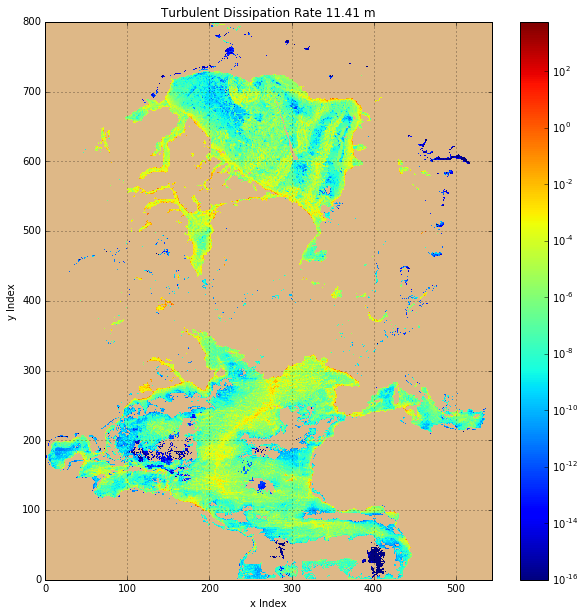

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cmap = plt.get_cmap('jet')
#cmap.set_bad('burlywood')
#clines = ax.contour(E,0.0,colors='white')
mesh = ax.pcolormesh(eps[8,:,:],norm=colors.LogNorm(vmin=10**(-16), vmax=eps.max()),cmap=cmap)

cbar = fig.colorbar(mesh,ax=ax)
#cbar.set_label('W/m^2')
plt.axis((0, eps.shape[2], 0, eps.shape[1]))

#clines = ax.contour(E,0.0,colors='white')
ax.grid()
ax.set_title('Turbulent Dissipation Rate {d:.2f} m'.format(d=depth[8]))
#ax.set_title('Turbulent Dissipation Rate',depth[40])
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cmap = plt.get_cmap('jet')
#cmap.set_bad('burlywood')
#clines = ax.contour(E,0.0,colors='white')
mesh = ax.pcolormesh(eps[45,:,:],norm=colors.LogNorm(vmin=0.00000001, vmax=eps.max()),cmap=cmap)

cbar = fig.colorbar(mesh,ax=ax)
#cbar.set_label('W/m^2')
plt.axis((0, E.shape[1], 0, E.shape[0]))

#clines = ax.contour(E,0.0,colors='white')
ax.grid()
ax.set_title('Turbulent Dissipation Rate {d:.2f} m'.format(d=depth[45]))
#ax.set_title('Turbulent Dissipation Rate',depth[40])
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')